In [1]:
"""
Analysis of modularity distribution from paradigmic analysis results,
colored by word categories (swadesh, custom, value, semantic_change_probe_list).
"""

import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import csv

# Import word lists from mine_vibes.py
import sys
sys.path.append('.')
from mine_vibes import swadesh_words, custom_words, value_words, number_words


/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_semantic_change_words():
    """Load words from the semantic change probe list CSV."""
    semantic_words = []
    try:
        with open('semantic_change_probe_list_small.csv', 'r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                word = row['Word'].strip()
                if word and word not in semantic_words:  # Avoid duplicates
                    semantic_words.append(word)
        print(f"Loaded {len(semantic_words)} words from semantic_change_probe_list.csv")
    except FileNotFoundError:
        print("Warning: semantic_change_probe_list.csv not found. Using empty list.")
    except Exception as e:
        print(f"Error loading semantic change words: {e}")
    
    return semantic_words

def categorize_word(word, swadesh_set, custom_set, value_set, semantic_set, numeric_set):
    """Categorize a word into one of the five categories."""
    if word in numeric_set:
        return 'Numeric'
    elif word in semantic_set:
        return 'Semantic Change'
    elif word in swadesh_set:
        return 'Swadesh'
    elif word in custom_set:
        return 'Custom'
    elif word in value_set:
        return 'Value'
    else:
        return 'Unknown'


In [3]:
def load_all_results():
    """Load all JSON results from paradigmic_analysis_results/*/*/*.json"""
    
    # Find all JSON result files
    json_files = glob.glob('paradigmic_analysis_results/*/*_results.json')
    print(f"Found {len(json_files)} JSON result files")
    
    # Load semantic change words
    semantic_words = load_semantic_change_words()
    
    # Convert word lists to sets for faster lookup
    swadesh_set = set(swadesh_words)
    custom_set = set(custom_words)
    value_set = set(value_words)
    semantic_set = set(semantic_words)
    numeric_set = set(number_words)
    
    # Load all results
    results = []
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                
            # Add category information
            word = data['word']
            category = categorize_word(word, swadesh_set, custom_set, value_set, semantic_set, numeric_set)
            data['category'] = category
            
            results.append(data)
            
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    print(f"Successfully loaded {len(results)} results")
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Print category distribution
    print("\nCategory distribution:")
    print(df['category'].value_counts())
    
    return df

# Load the data
df = load_all_results()


Found 232 JSON result files
Loaded 50 words from semantic_change_probe_list.csv
Successfully loaded 232 results

Category distribution:
category
Swadesh            95
Unknown            54
Semantic Change    50
Numeric            20
Value              11
Custom              2
Name: count, dtype: int64


Creating normalized density histogram:
Saved histogram to modularity_histogram_manuscript_density.png


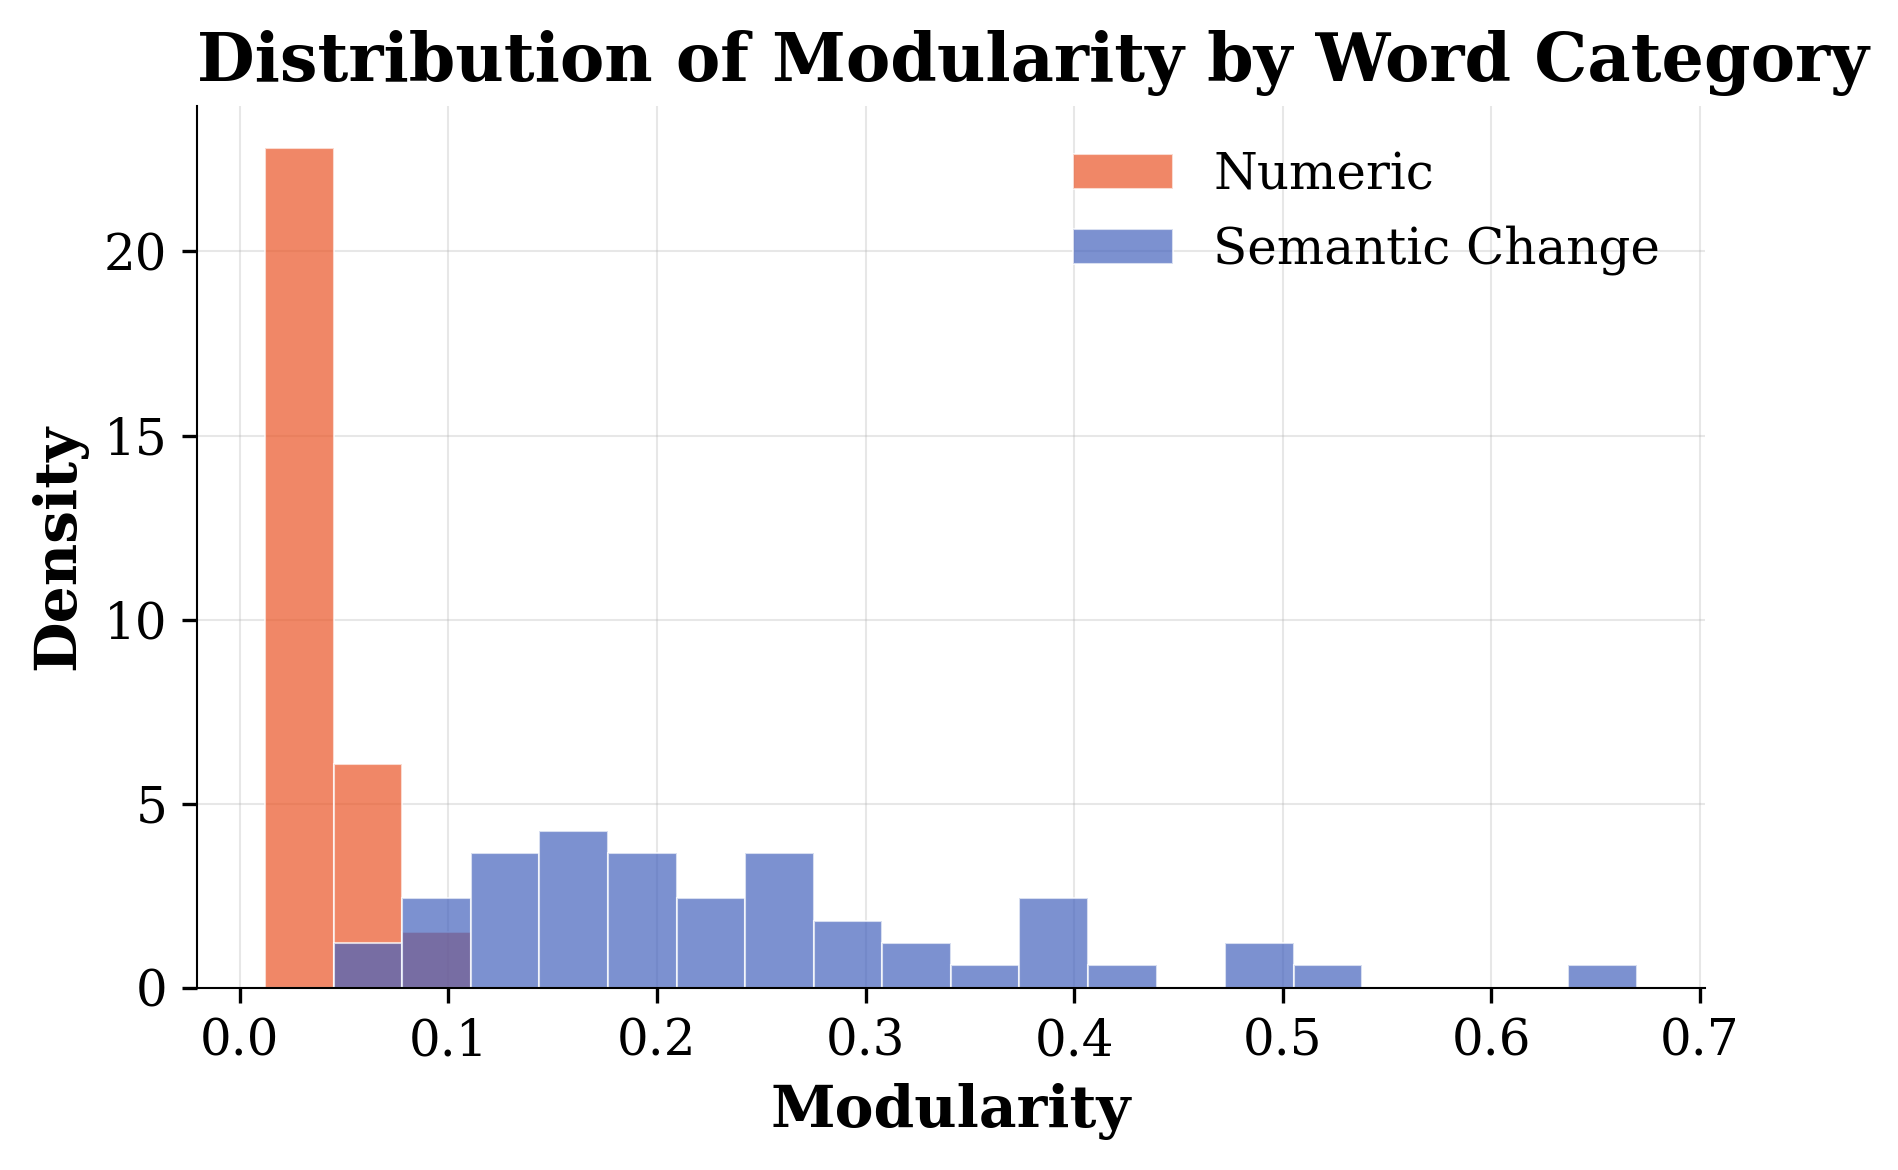


Creating step histogram (alternative approach):
Saved histogram to modularity_histogram_manuscript_step.png


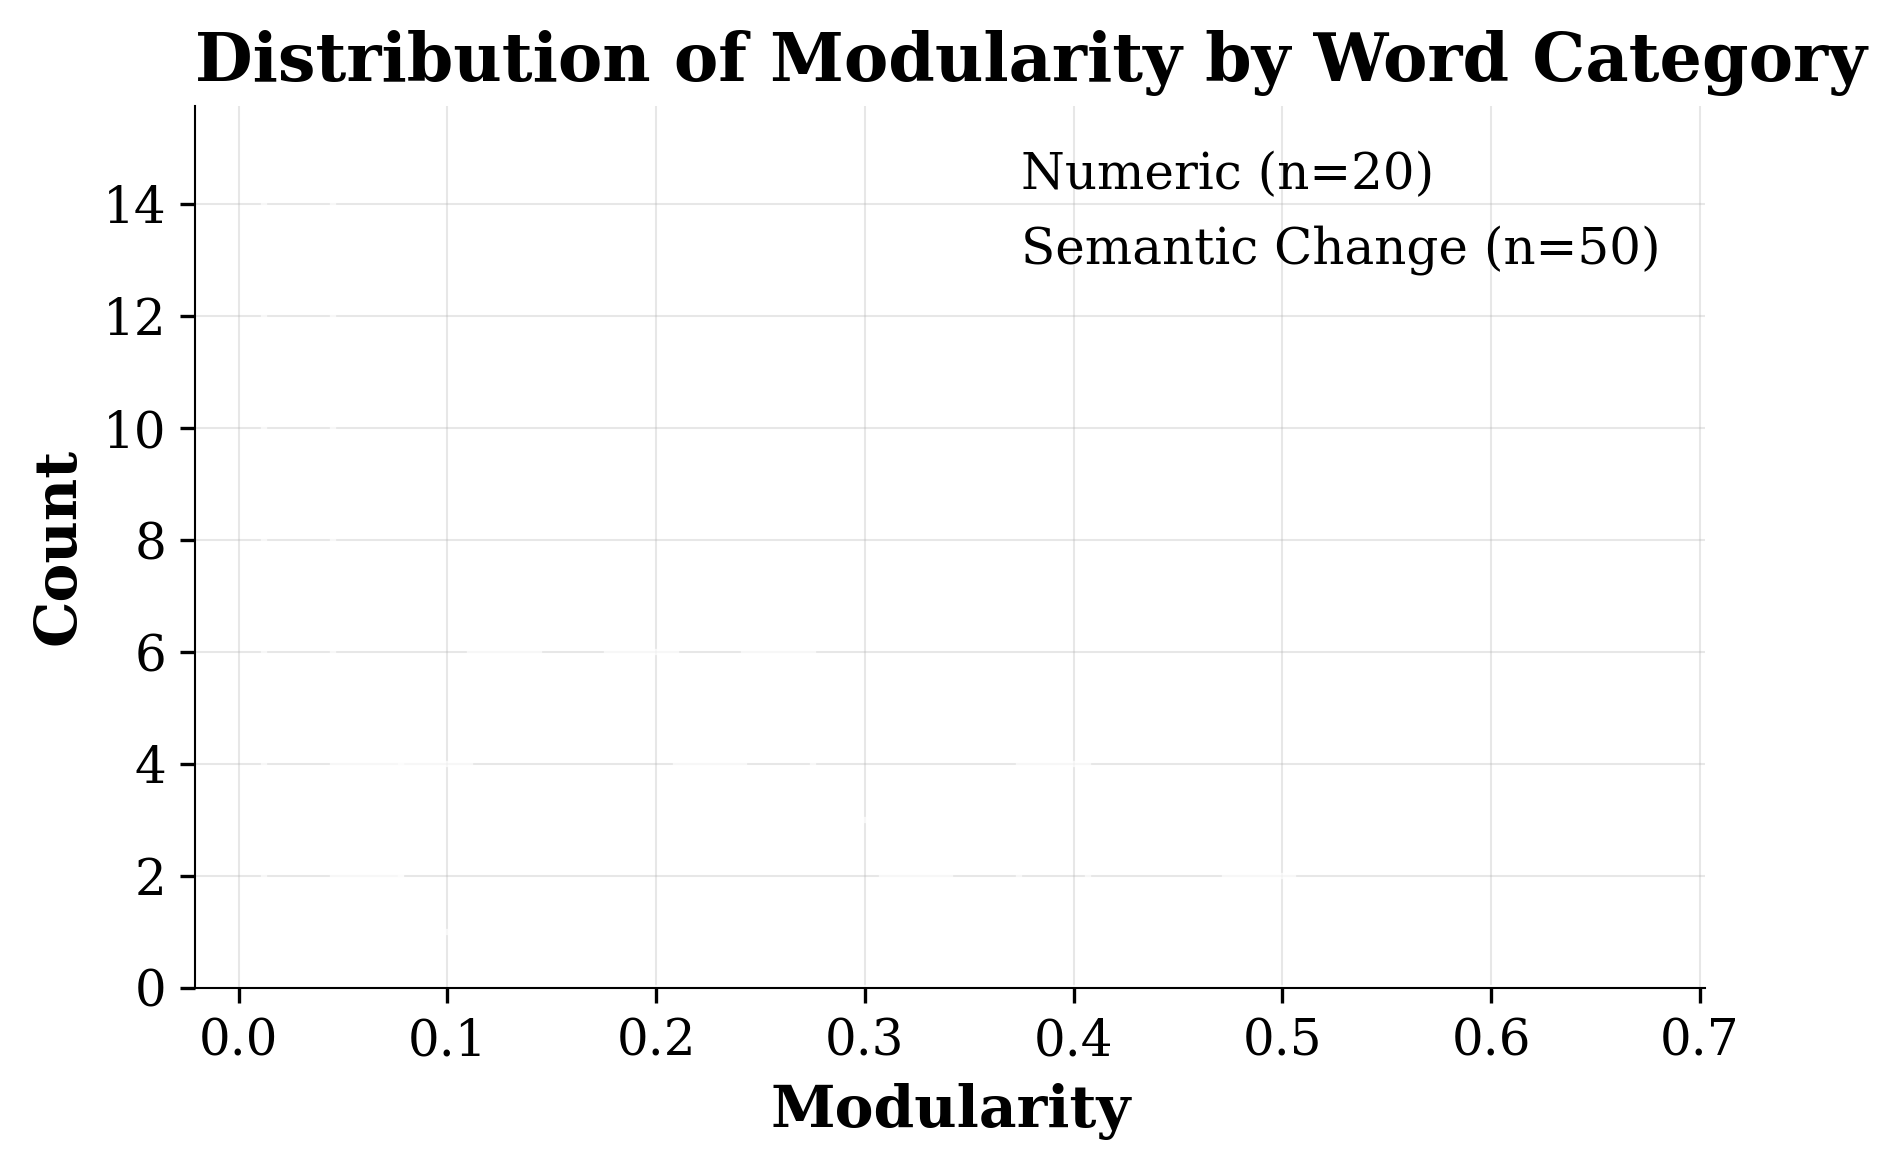

In [20]:
def create_manuscript_histogram(df, categories_to_plot=['Numeric', 'Semantic Change'], 
                               saveas=None, title_suffix="", normalize=True):
    """
    Create a single-column manuscript-ready histogram of modularity distribution.
    Similar styling to visualize_process_small from climate_change.ipynb.
    
    Args:
        df: DataFrame with modularity data and categories
        categories_to_plot: List of categories to include in the plot
        saveas: Optional filename to save PNG (without extension)
        title_suffix: Optional suffix to add to the title
        normalize: If True, normalize histograms to show density instead of raw counts
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Filter data for specified categories
    filtered_df = df[df['category'].isin(categories_to_plot)]
    
    if len(filtered_df) == 0:
        print("No data found for specified categories.")
        return
    
    # Define colors using the same palette as climate_change.ipynb
    good_colors = ['#EA5526', '#4462BD', '#51915B', '#8064A2', '#E5B700']
    category_colors = {
        'Numeric': good_colors[0],         
        'Semantic Change': good_colors[1],
        'Swadesh': good_colors[2],
        'Custom': good_colors[3],
        'Value': good_colors[4]
    }
    
    # Create matplotlib figure optimized for single column manuscript
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)  # Single column width, high DPI
    
    # Determine common bin edges across all categories for fair comparison
    all_data = filtered_df['modularity']
    bins = np.linspace(all_data.min(), all_data.max(), 21)  # 20 bins
    
    # Create overlapping histograms with normalization
    for i, category in enumerate(categories_to_plot):
        cat_data = filtered_df[filtered_df['category'] == category]['modularity']
        
        if len(cat_data) == 0:
            continue
            
        color = category_colors.get(category, good_colors[i % len(good_colors)])
        
        # Create histogram with density normalization to make bars more comparable
        if normalize:
            # Use density=True to normalize by area, making different sample sizes comparable
            n, bins_edges, patches = ax.hist(cat_data, bins=bins, alpha=0.7, 
                                            color=color, label=f'{category}',
                                            edgecolor='white', linewidth=0.5,
                                            density=True)
        else:
            # Alternative: use step histograms which show shape better for small samples
            ax.hist(cat_data, bins=bins, alpha=0.7, 
                   color=color, label=f'{category} (n={len(cat_data)})',
                   edgecolor='white', linewidth=1.5, histtype='step')
    
    # Customize appearance for manuscript
    ax.set_xlabel('Modularity', fontfamily='serif', fontsize=14, fontweight='bold')
    
    if normalize:
        ax.set_ylabel('Density', fontfamily='serif', fontsize=14, fontweight='bold')
    else:
        ax.set_ylabel('Count', fontfamily='serif', fontsize=14, fontweight='bold')
    
    # Create title
    base_title = 'Distribution of Modularity by Word Category'
    # Move title to the right: use loc='right' for right alignment, plus adjust pad as needed
    ax.set_title(
        base_title, 
        fontfamily='serif', 
        fontsize=16, 
        fontweight='bold', 
        loc='left'   # Align the title to the right
    )
    
    # Set tick parameters
    ax.tick_params(axis='both', labelsize=12)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('serif')
    
    # Legend with larger text
    #legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
    #                  fontsize=12, frameon=False)
    legend = ax.legend(loc='upper right', 
                      fontsize=12, frameon=False)

    for text in legend.get_texts():
        text.set_fontfamily('serif')
    
    # Remove spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Add subtle grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Tight layout to prevent clipping
    plt.tight_layout()
    
    # Save as PNG if filename provided
    if saveas:
        if not saveas.endswith('.png'):
            saveas += '.png'
        plt.savefig(saveas, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Saved histogram to {saveas}")
    
    plt.show()

# Create the manuscript-ready histogram with density normalization (makes different sample sizes comparable)
print("Creating normalized density histogram:")
create_manuscript_histogram(df, categories_to_plot=['Numeric', 'Semantic Change'], 
                          saveas='modularity_histogram_manuscript_density', normalize=True)

print("\nCreating step histogram (alternative approach):")
create_manuscript_histogram(df, categories_to_plot=['Numeric', 'Semantic Change'], 
                          saveas='modularity_histogram_manuscript_step', normalize=False)


In [4]:
# Create the modularity count plot for only Numeric and Semantic Change words using Plotly
# On mouseover, show the list of words in the moused over bin
# Bars have the same width for both categories, but the number of bins may differ
# Instead of annotating the means and medians on the plot, specify them in the legend

import plotly.graph_objs as go
import numpy as np
import urllib.request
import matplotlib.font_manager as fm

# Download and set the Junicode font (matching climate_change.ipynb style)
font_url = "http://calcifercomputing.com/fonts/junicode/TTF/Junicode-Regular.ttf"
font_path = "/tmp/Junicode-Regular.ttf"
urllib.request.urlretrieve(font_url, font_path)
junicode_prop = fm.FontProperties(fname=font_path)

# Include Numeric and Semantic Change categories
categories_to_plot = ['Numeric', 'Semantic Change']
filtered_df = df[df['category'].isin(categories_to_plot)]

# Define colors using the same palette as climate_change.ipynb
good_colors = ['#EA5526', '#4462BD', '#51915B', '#8064A2', '#E5B700']
category_colors = {
    'Numeric': good_colors[0],         
    'Semantic Change': good_colors[1],
}

# Set a fixed bar width for all bars (e.g., 0.03 modularity units)
fixed_bar_width = 0.03

# Store mean/median for legend
category_stats = {}

# Create custom histogram traces with hover text showing words in each bin
traces = []

for category in categories_to_plot:
    cat_df = filtered_df[filtered_df['category'] == category]
    modularity_values = cat_df['modularity'].values
    words = cat_df['word'].values

    if len(modularity_values) == 0:
        continue

    # Compute bin edges for this category, using the fixed bar width
    bin_min = np.min(modularity_values)
    bin_max = np.max(modularity_values)
    # Ensure at least one bin
    nbins = max(1, int(np.ceil((bin_max - bin_min) / fixed_bar_width)))
    # Recompute bin edges to cover the full range
    bin_edges = np.linspace(bin_min, bin_min + nbins * fixed_bar_width, nbins + 1)

    # Assign each value to a bin
    bin_indices = np.digitize(modularity_values, bin_edges) - 1  # bins are 0-indexed

    # Prepare bin counts and hovertext
    bin_counts = np.zeros(nbins)
    bin_word_lists = [[] for _ in range(nbins)]

    for idx, bin_idx in enumerate(bin_indices):
        # Clamp bin_idx to valid range
        if bin_idx < 0:
            bin_idx = 0
        elif bin_idx >= nbins:
            bin_idx = nbins - 1
        bin_counts[bin_idx] += 1
        bin_word_lists[bin_idx].append(words[idx])

    # Prepare hover text: show words in each bin (up to 10, then "and N more")
    hover_texts = []
    for word_list, left, right in zip(bin_word_lists, bin_edges[:-1], bin_edges[1:]):
        if len(word_list) == 0:
            hover_texts.append(f"Modularity: {left:.3f}–{right:.3f}<br>No words")
        else:
            display_words = word_list[:10]
            more_count = len(word_list) - len(display_words)
            word_str = ', '.join(display_words)
            if more_count > 0:
                word_str += f", and {more_count} more"
            hover_texts.append(
                f"Modularity: {left:.3f}–{right:.3f}<br>Words ({len(word_list)}):<br>{word_str}"
            )

    # Calculate mean and median
    mean_mod = np.mean(modularity_values)
    median_mod = np.median(modularity_values)
    category_stats[category] = (mean_mod, median_mod, int(np.sum(bin_counts)))

    # Use bar for custom hovertext, plotting counts (not density)
    traces.append(
        go.Bar(
            x=0.5 * (bin_edges[:-1] + bin_edges[1:]),  # bin centers
            y=bin_counts,
            width=fixed_bar_width,
            name=f"{category} Set",
            opacity=0.7,
            marker_color=category_colors.get(category, good_colors[3]),
            hovertext=hover_texts,
            hoverinfo='text',
            marker_line_width=0.5,
            marker_line_color='black',
            hovertemplate=f'<b>{category}</b><br>%{{hovertext}}<extra></extra>'
        )
    )

# Create the layout matching climate_change.ipynb styling
layout = go.Layout(
    title=dict(
        text='Distribution of Modularity by Word Category',
        font=dict(family="Junicode", size=24, color="black"),
        x=0.5
    ),
    xaxis=dict(
        title=dict(text='Modularity', font=dict(family="Junicode", size=20, color="black")),
        tickfont=dict(family="Geist Mono", size=16, color="black"),
        linecolor='black',
        linewidth=1,
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        title=dict(text='Count', font=dict(family="Junicode", size=20, color="black")),
        tickfont=dict(family="Geist Mono", size=16, color="black"),
        linecolor='black',
        linewidth=1,
        showgrid=False,
        zeroline=False
    ),
    barmode='overlay',
    legend=dict(
        x=0.7, y=0.95,
        bgcolor='rgba(0,0,0,0)',  # Transparent background
        font=dict(family="Junicode", size=16, color="black"),
        itemclick='toggle',      # Allow toggling traces on/off by clicking legend
        itemdoubleclick='toggleothers'  # Double-click to isolate
    ),
    hoverlabel=dict(
        font=dict(family="Geist Mono", size=12)
    ),
    width=1000,
    height=500,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    showlegend=True
)

fig = go.Figure(data=traces, layout=layout)
config={'displayModeBar': False}
fig.show(config=config)
fig.write_html('modularity_dist.html', config=config)
